# Magic states and T-gadgets with Qiskit

## Theory


Assume that we want to prepare (or simulate) 
$$\rho=U |0\dots0 \rangle_{\rm sys} \langle 0\dots 0|_{\rm sys} U^\dagger,$$

where $U$ is an arbitrary circuit compiled into the $H$, $S$, $CNOT$, $T$ gateset.

Assume that the number of $T$ gates, also known as T-count, is $t$.

Using magic states and T-gadgets, it can be shown [Bravyi, Gosset (2016)](https://arxiv.org/abs/1601.07601) that:

$$\rho = 2^t \, {\rm tr_{aux}}[\rho' (I \otimes |0\dots0 \rangle_{\rm aux} \langle 0\dots 0|_{\rm aux}) ],$$

where $$\rho'= U' (|0\dots0 \rangle_{\rm sys}\langle 0\dots 0|_{\rm sys} \otimes |T\dots T \rangle_{\rm aux}  \langle T\dots T|_{\rm aux}) U'^\dagger,$$

$|T\dots T \rangle_{\rm aux}  \langle T\dots T|_{\rm aux}$ is the tensor product of $t$ magic states.

$$|T\rangle = T\, H\, |0\rangle, \text{ (magic state)}$$  

and, **importantly**, $U'$ is a Clifford circuit.

More precisely, $U'$ is obtained from $U$ by replacing all $T$ gates with $CNOT$ gates connecting qubits of the system and magic states.

**NOTE:** This is just a particular way of using T-gadgets and it corresponds to just a particular post-selected string of results on the auxiliary qubits (the string with $0 \dots 0$).


## Setting

In [1]:
from copy import deepcopy

import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli

import numpy as np
from matplotlib import pyplot as plt

seed = 2
n_qubits = 5
num_t = 12
num_1q_cliff = 500
num_cnots = 500
num_paulis = 4 ** 5
num_paulis = min(num_paulis, 4 ** n_qubits)

# Simulations to be run
density_matrix = True
extended_stabilizer = False
truncated_heisenberg = True

## Helper functions

In [2]:
def chop_and_real(x, eps = 1e-10):
    """Chop values of Numpy arrays."""
    y = np.copy(x)
    y[np.abs(x) < eps] = 0
    return np.real(y)

def random_pauli_string(n_qubits, seed=None):
    """Sample a random pauli string. """
    if seed is None:
        rnd_state = np.random
    else:
        rnd_state = np.random.RandomState(seed)  
    rnd_paulis = rnd_state.choice(["I", "X", "Y", "Z"], n_qubits, replace=True)
    return "".join(rnd_paulis)

random_pauli_string(5)

'IIIZZ'

In [3]:
def sample_pauli_strings(num_paulis, n_qubits, with_replacement=False, seed=0):
    """Returns a list of random Pauli strings sorted from many Is to few Is."""
    max_iterations = 4 ** (n_qubits + 3)
    sampled_paulis = []

    for j in range(max_iterations):
        if len(sampled_paulis) == num_paulis:
            sampled_paulis = sorted(
                sampled_paulis, key=lambda x: -sum([int(c=="I") for c in x])
            )
            return sampled_paulis
        
        sampled_paulis.append(random_pauli_string(n_qubits, seed=seed+j))
        
        if not with_replacement:
            sampled_paulis = list(set(sampled_paulis))
            
    raise RuntimeError("Max number of iterations reached.")



sample_pauli_strings(4 ** 1, n_qubits=n_qubits)

['YIXZI', 'IZXIY', 'XZIIZ', 'IZXIZ']

## Generate a random Clifford+T circuit.

In [4]:
def rnd_clifford_t_circuit(n_qubits, num_t, num_1q_cliff, num_cnots, t_gadget=False, randomize=False, magic_prep=True, seed=None, seed_s=None):
    """Returns a random circuit with Clifford gates and T gates.
    
    Args:
        n_qubits: The number of qubits.
        num_t: The number T gates (determines also the number of random gate layers too).
        t_gadget: If True, num_t auxiliary qubits are introduced and all T gates are replaced with a T-gadget.
        randomize: If True, S and X gates are randomly added to T-gadgets, producing equivalent gadgets.
        magic_prep: If True magic states |T> are prepared (with H and T gates).
        seed: The seed for the random generation of gate layers.
        seed_s: The seed associated only to the gadget randomization (see "randomize" option).
    """
    
    if n_qubits < 2:
        raise ValueError("The number of qubits must be at least 2.")

    # init rnd number generator
    if seed is None:
        rnd_state = np.random
    else:
        rnd_state = np.random.RandomState(seed)

    if seed is None:
        rnd_state_s = np.random
    else:
        rnd_state_s = np.random.RandomState(seed_s)

    # Init circuit
    if not t_gadget:
        circuit = QuantumCircuit(n_qubits)
    else:
        circuit = QuantumCircuit(n_qubits + num_t)
        # Prepare magic states
        if magic_prep:
            for idx in range(num_t):
                circuit.h(n_qubits + idx)
                circuit.t(n_qubits + idx)
                
    # Deterministic layer of Hadamards
    for idx in range(n_qubits):
        circuit.h(idx)
        
    # Random part of the circuit
    qubit_indices = list(range(n_qubits))
    mask = np.array(["1q"] * num_1q_cliff + ["2q"] * num_cnots + ["t"] * num_t)
    rnd_state.shuffle(mask)
    t_counter = 0
    for label in mask:       
        if label == "1q":
            # Apply random single-qubit Clifford gates to random qubits
            q = rnd_state.choice(qubit_indices, 1)
            if rnd_state.randint(2):
                circuit.h(q)
            else:
                circuit.s(q)
        elif label == "2q":
            # Apply CNOT gate to random qubits
            control, target = rnd_state.choice(qubit_indices, 2, replace=False)
            circuit.cx(control, target)
        elif label == "t":
            # Apply T gate to random qubit
            q_t = rnd_state.choice(qubit_indices, 1)
            if not t_gadget:
                circuit.t(q_t)
            elif not randomize:
                circuit.cnot(q_t, n_qubits + t_counter)
            else:
                circuit.cnot(q_t, n_qubits + t_counter)
                if rnd_state_s.randint(2): # apply t-gadget adaptive correction
                    circuit.s(q_t)
                    circuit.x(n_qubits + t_counter)
            t_counter += 1
        else:
            raise RuntimeError("Bad label.")       

    return circuit

Let us print a random Clifford+T circuit:

In [5]:
circuit = rnd_clifford_t_circuit(
    n_qubits=n_qubits, num_t=num_t, num_1q_cliff=num_1q_cliff, num_cnots=num_cnots, t_gadget=False, seed=seed
)
print(circuit)

     ┌───┐                         ┌───┐     ┌───┐┌───┐┌───┐┌───┐          »
q_0: ┤ H ├─────────────────────────┤ X ├──■──┤ H ├┤ H ├┤ S ├┤ X ├───────■──»
     ├───┤┌───┐          ┌───┐┌───┐└─┬─┘┌─┴─┐└───┘└───┘└───┘└─┬─┘┌───┐  │  »
q_1: ┤ H ├┤ S ├───────■──┤ X ├┤ S ├──┼──┤ X ├───────■─────────■──┤ S ├──┼──»
     ├───┤└───┘       │  └─┬─┘└───┘  │  ├───┤┌───┐┌─┴─┐     ┌───┐└───┘  │  »
q_2: ┤ H ├────────────┼────┼─────────┼──┤ X ├┤ H ├┤ X ├─────┤ X ├──■────┼──»
     ├───┤┌───┐     ┌─┴─┐  │  ┌───┐  │  └─┬─┘├───┤├───┤┌───┐└─┬─┘  │    │  »
q_3: ┤ H ├┤ X ├──■──┤ X ├──┼──┤ H ├──┼────■──┤ H ├┤ X ├┤ H ├──┼────┼────┼──»
     ├───┤└─┬─┘┌─┴─┐├───┤  │  └───┘  │       └───┘└─┬─┘└───┘  │  ┌─┴─┐┌─┴─┐»
q_4: ┤ H ├──■──┤ X ├┤ S ├──■─────────■──────────────■─────────■──┤ X ├┤ X ├»
     └───┘     └───┘└───┘                                        └───┘└───┘»
«     ┌───┐                         ┌───┐┌───┐               ┌───┐┌───┐┌───┐»
«q_0: ┤ H ├─────────────────────────┤ X ├┤ H ├───────────────┤ X ├┤ H ├┤ X 

Let us print the corresponding T-gadget version (assuming auxiliary qubits are projected on the zero state).

In [6]:
circuit_with_gadgets = rnd_clifford_t_circuit(
    n_qubits=n_qubits, num_t=num_t, num_1q_cliff=num_1q_cliff, num_cnots=num_cnots, t_gadget=True, randomize=False, seed=seed
)
print(circuit_with_gadgets)

      ┌───┐                         ┌───┐     ┌───┐┌───┐┌───┐┌───┐          »
 q_0: ┤ H ├─────────────────────────┤ X ├──■──┤ H ├┤ H ├┤ S ├┤ X ├───────■──»
      ├───┤┌───┐          ┌───┐┌───┐└─┬─┘┌─┴─┐└───┘└───┘└───┘└─┬─┘┌───┐  │  »
 q_1: ┤ H ├┤ S ├───────■──┤ X ├┤ S ├──┼──┤ X ├───────■─────────■──┤ S ├──┼──»
      ├───┤└───┘       │  └─┬─┘└───┘  │  ├───┤┌───┐┌─┴─┐     ┌───┐└───┘  │  »
 q_2: ┤ H ├────────────┼────┼─────────┼──┤ X ├┤ H ├┤ X ├─────┤ X ├──■────┼──»
      ├───┤┌───┐     ┌─┴─┐  │  ┌───┐  │  └─┬─┘├───┤├───┤┌───┐└─┬─┘  │    │  »
 q_3: ┤ H ├┤ X ├──■──┤ X ├──┼──┤ H ├──┼────■──┤ H ├┤ X ├┤ H ├──┼────┼────┼──»
      ├───┤└─┬─┘┌─┴─┐├───┤  │  └───┘  │       └───┘└─┬─┘└───┘  │  ┌─┴─┐┌─┴─┐»
 q_4: ┤ H ├──■──┤ X ├┤ S ├──■─────────■──────────────■─────────■──┤ X ├┤ X ├»
      ├───┤┌───┐└───┘└───┘                                        └───┘└───┘»
 q_5: ┤ H ├┤ T ├────────────────────────────────────────────────────────────»
      ├───┤├───┤                                                

## Brute force density-matrix execution of the circuit

In [7]:
def compute_pauli_expval_with_state(circuit, pauli, backend = None, rho=None):
    """Compute the expectation value of a Pauli observable.
    Returns also the density matrix.
    """
    obs = qiskit.quantum_info.Pauli(pauli).to_matrix()
    if rho is not None:
        return chop_and_real(np.trace(rho @ obs)), rho
  
    circuit_to_measure = circuit.copy()

    if backend is None:
        backend = qiskit.Aer.get_backend('aer_simulator')
        circuit_to_measure.save_density_matrix()

    job = backend.run(circuit_to_measure)
    result = job.result()
      
    if not result.success:
        print("Simulation failed")
    
    if backend.name() == 'aer_simulator_extended_stabilizer':
        # Fake rho just to test speed
        rho = np.eye(2 ** (n_qubits))
    else:
        rho = result.data()["density_matrix"]
    
    return chop_and_real(np.trace(rho @ obs)), rho

pauli_to_measure = "Z"+ "".join((n_qubits - 1) * ["I"])
circuit = rnd_clifford_t_circuit(
    n_qubits=n_qubits, num_t=num_t, num_1q_cliff=num_1q_cliff, num_cnots=num_cnots, t_gadget=False, seed=seed
)
compute_pauli_expval_with_state(circuit, pauli=pauli_to_measure)[0]

array(-0.1767767)

# T-gadget simulation

We simulate the same circuit using T-gadgets and projecting on the $|0\dots 0\rangle \langle  0 \dots 0 |_{\rm aux}$ state as discussed in the initial part of this notebook  (*Theory* section).

In [8]:
def compute_pauli_expval_with_gadget(circuit, pauli):
    """Compute the expectation value of a Pauli observable.
    """

    circuit_to_measure = circuit.copy()
    circuit_to_measure.save_density_matrix()

    #backend = AerSimulator(method='extended_stabilizer')
    backend = qiskit.Aer.get_backend('aer_simulator_statevector')
    job = backend.run(circuit_to_measure)
    result = job.result()

    if not result.success:
        print("Simulation failed")

    rho = result.data()["density_matrix"]
    
    extended_pauli = num_t*"I" + pauli
    obs = qiskit.quantum_info.Pauli(extended_pauli).to_matrix()
    
    # Define projector on gadget qubits
    id_on_sys = np.eye(2 ** n_qubits)
    proj_on_zero_aux = np.zeros((2 ** num_t, 2 ** num_t))
    proj_on_zero_aux[0, 0] = 1
    
    gadjet_projector = np.kron(proj_on_zero_aux, id_on_sys)
    return (2 ** num_t) * chop_and_real(np.trace(rho @ obs @ gadjet_projector))

circuit_without_t = rnd_clifford_t_circuit(
    n_qubits=n_qubits, num_t=num_t, num_1q_cliff=num_1q_cliff, num_cnots=num_cnots, t_gadget=True, randomize=True, seed=seed, seed_s=1,
)
# compute_pauli_expval_with_gadget(circuit_without_t, pauli="Z" + (n_qubits - 1) * "I")

## Evaluating expectation values in the Heisenberg picture with T-gadgets

Assume that we are not interested in simulating measurement outcomes but that we just want to compute an expectation value $E= {\rm tr}(\rho P)$, where $\rho=U |0\dots0 \rangle_{\rm sys} \langle 0\dots 0|_{\rm sys} U^\dagger$ and $P$ is a Pauli operator.

The previous code shows that, by using T-gadgets, we can evaluate the same expectation value as:

$$E= 2^t \, {\rm tr}[\rho' (P \otimes |0\dots0 \rangle_{\rm aux} \langle 0\dots 0|_{\rm aux}) ],$$

where $$\rho'= U' (|0\dots0 \rangle_{\rm sys}\langle 0\dots 0|_{\rm sys} \otimes |T\dots T \rangle_{\rm aux}  \langle T\dots T|_{\rm aux}) U'^\dagger,$$

$|T\rangle = T\, H\, |0\rangle$ is a magic state and, importantly, $U'$ is a **Clifford circuit** in which a number $t$ of $T$ gates have been replaced by T-gadgets.

If the observable is a Pauli operator, can we use the Heisenberg-picture to evaluate its expectation value? The motivation for using the Heisenberg-picture is that Pauli operators are (efficiently) mapped to Pauli operators by Clifford circuits ($U'$ in our case). Moreover, since the initial state is the tensor product of single-qubit states, evaluating the expectation value of a Pauli string is trivial.

Unfortunately, the full observable that we need to evolve is not a Pauli operator $(P \otimes |0\dots0 \rangle_{\rm aux} \langle 0\dots 0|_{\rm aux})$. So, if we want to 

This requires expanding final zero-state-projector on the auxiliary qubits as a linear combination of Pauli strings. We use:

$$ |0\dots 0 \rangle \langle 0\dots 0| = \prod_{j=1}^{t} \frac{(I_j + Z_j)}{2}=\frac{1}{2^t}\sum_{b \in \{0, 1\}^{\otimes t}} Z^{b_1}Z^{b_2}\dots Z^{b_t}. $$

So it is possible to expand $P \otimes |0\dots0 \rangle_{\rm aux} \langle 0\dots 0|_{\rm aux}$ as a linear combination of Pauli strings. Unfortunately the number of terms is $2^t$, so exponential in $t$.

In [9]:
def paulis_of_zero_projector(num_t, max_z_weight):
    """Returns a list of pauli strings corresponding (up to normalization)
    to the projector on the zero state of n_qubits"""
    paulis = ["I", "Z"]
    for _ in range(num_t - 1):
        new_paulis = []
        for pauli in paulis:
            new_paulis.append(pauli + "I")
            new_paulis.append(pauli + "Z")
        paulis = new_paulis

    # Discard pauli operators with high too many Zs
    truncated_paulis = [p for p in paulis if sum([int(c=="Z") for c in p]) <= max_z_weight]
    
    # Sort from few Zs to many Zs
    return sorted(truncated_paulis, key=lambda x: sum([int(c=="Z") for c in x]))

paulis_of_zero_projector(3, max_z_weight=2)

['III', 'IIZ', 'IZI', 'ZII', 'IZZ', 'ZIZ', 'ZZI']

In [10]:
def paulis_of_zero_projector_evolved(circuit, n_qubits, num_t, max_z_weight):
    """Returns the pauli operators of the magic state projector (on the zero state) 
    evolved by the input circuit (in the Heisenberg picture)."""
    
    # Evolve generators
    generators = paulis_of_zero_projector(num_t, max_z_weight=1)[1:]
    evolved_generators = [Pauli(p + n_qubits * "I").evolve(circuit) for p in generators]
    
    # Multiply evolved generators
    projector_paulis = paulis_of_zero_projector(num_t, max_z_weight)
    evolved = []
    for p in projector_paulis:
        evolved_pauli = Pauli((n_qubits + num_t) * "I")
        for local_p, gen in zip(p, evolved_generators):
            if local_p == "Z":
                evolved_pauli = evolved_pauli.dot(gen)
        evolved.append(evolved_pauli)    
    return evolved

# Example
circuit = rnd_clifford_t_circuit(
    n_qubits=n_qubits, num_t=num_t, num_1q_cliff=num_1q_cliff, num_cnots=num_cnots, t_gadget=True, randomize=False, magic_prep=False, seed=seed
)
proj_evolved = paulis_of_zero_projector_evolved(circuit, n_qubits, num_t, num_t)
proj_evolved

[Pauli('IIIIIIIIIIIIIIIII'),
 Pauli('ZIXXXXXXIXXXIZYZZ'),
 Pauli('-IZIXXIIXIIIXZXIZY'),
 Pauli('-IIZXIIXIXXIXIZZZZ'),
 Pauli('-IIIZIXIXIXXXXZXYY'),
 Pauli('-IIIIZIIXXIIXZIYZX'),
 Pauli('-IIIIIZXXIXIIIZYZX'),
 Pauli('IIIIIIZIIIIXIXIZI'),
 Pauli('IIIIIIIZIIIIXXZZY'),
 Pauli('IIIIIIIIZIXIIYZYY'),
 Pauli('-IIIIIIIIIZXXIYIYY'),
 Pauli('-IIIIIIIIIIZXYXZZX'),
 Pauli('IIIIIIIIIIIZYZXZZ'),
 Pauli('-ZZXIIXXIIXXIZYYIX'),
 Pauli('-ZIYIXXIXXIXIIIXII'),
 Pauli('IZZIXIXXXXIIZYZIX'),
 Pauli('-ZIXYXIXIIIIIXIZXX'),
 Pauli('-IZIYXXIIIXXIYYXXI'),
 Pauli('-IIZYIXXXXIXIXIYXX'),
 Pauli('-ZIXXYXXIXXXIZZIIY'),
 Pauli('-IZIXYIIIXIIIIXYIZ'),
 Pauli('IIZXZIXXIXIIZZXIY'),
 Pauli('IIIZZXIIXXXIYZZXZ'),
 Pauli('-ZIXXXYIIIIXXIIIIY'),
 Pauli('-IZIXXZXIIXIXZYYIZ'),
 Pauli('IIZXIZIXXIIXIIXIY'),
 Pauli('IIIZIYXIIIXXXIZXZ'),
 Pauli('IIIIZZXIXXIXZZIII'),
 Pauli('ZIXXXXYXIXXIIYYIZ'),
 Pauli('-IZIXXIZXIIIIZIIIY'),
 Pauli('-IIZXIIYIXXIIIYZIZ'),
 Pauli('IIIZIXZXIXXIXYXXY'),
 Pauli('-IIIIZIZXXIIIZXYIX'),
 Pauli('-IIIIIZYXIXIXIYY

## Magic state |T> in the Pauli basis

The magic sate $|T\rangle=TH|0\rangle$ has known expectation values with respect to the Pauli basis: 
$$\langle T | I |T\rangle=1,$$ 
$$\langle T | Y |T\rangle=\langle T | X |T\rangle=1/\sqrt{2},$$
$$\langle T | Z |T\rangle=0.$$

We numerically verify this fact.

In [11]:
t_circuit = QuantumCircuit(1)
t_circuit.h(0)
t_circuit.t(0)

assert np.isclose(compute_pauli_expval_with_state(t_circuit, "I")[0], 1)
assert np.isclose(compute_pauli_expval_with_state(t_circuit, "X")[0], 1 / np.sqrt(2))
assert np.isclose(compute_pauli_expval_with_state(t_circuit, "Y")[0], 1 / np.sqrt(2))
assert np.isclose(compute_pauli_expval_with_state(t_circuit, "Z")[0], 0)

## Linear combination of paulis using Clifford rules


In [12]:
def expval_with_init_state(pauli, n_qubits, num_t):
    """Evaluates the expectation value of the input Pauli with respect to the initial state of the
    system i.e., |psi> = |0_{1} ... O_{num_qubits}> |T_{1} ... T_{num_t}>.
    """
    
    string = pauli.to_label()
    expval = 1.0

    # Check extract sign from string
    if string[0] == "-":
        expval = -1.0
        string = string[1:]

    # The right part of the string is associated to the system
    sys_string = string[-n_qubits:]
    # The left part of the string is associated to the magic states
    magic_string = string[:num_t]
    assert len(sys_string) + len(magic_string) == len(string)

    # First consider all the cases in which the result is zero
    if "X" in sys_string or "Y" in sys_string or "Z" in magic_string:
        return 0.0
    
    # Evaluate expectation as a product of single-qubit non-zero terms
    for p in magic_string:
        if p in ["X", "Y"]:
            expval *= 1 / np.sqrt(2)
    
    return expval

test_string = "".join(num_t * ["X"] + n_qubits * ["Z"])
assert np.isclose(
    expval_with_init_state(Pauli(test_string), n_qubits=n_qubits, num_t=num_t),
    np.sqrt(2) ** -num_t
)

In [13]:
def compute_pauli_expval_with_gadget_and_linear_comb_heisenberg(circuit, pauli, n_qubits, num_t, max_z_weight, proj_paulis=None):
    """Computes the expectation value of a Pauli observable expanding the projector on the magic states
    as a linear combination of Pauli operators. Each Pauli term is evolved by the circuit
    and evaluated using the Heisenberg picture.
    
    Returns: The expectation value and also individual terms before averaging.
    """
    if proj_paulis is None:
        proj_paulis = paulis_of_zero_projector_evolved(circuit, n_qubits, num_t, max_z_weight)
    
    #before = time()
    p_evolved = Pauli(num_t * "I" + p).evolve(circuit)
    #print("p_evolved time", time() - before)
    #before = time()
    evolved_paulis = [p_evolved.dot(p) for p in proj_paulis]
    #print("evolved_paulis time", time() - before)

    #before = time()
    all_expvals = np.array([expval_with_init_state(p, n_qubits, num_t) for p in evolved_paulis])
    #print("all_expvals time", time() - before)

    return np.sum(all_expvals), all_expvals

### Direct simulation

In [14]:
sampled_paulis = sample_pauli_strings(n_qubits=n_qubits, num_paulis=num_paulis, with_replacement=False, seed=seed)
print(f"{len(sampled_paulis)} random Paulis sampled.")

1024 random Paulis sampled.


In [15]:
%%time
if density_matrix:
    circuit = rnd_clifford_t_circuit(
        n_qubits=n_qubits, num_t=num_t, num_1q_cliff=num_1q_cliff, num_cnots=num_cnots, t_gadget=False, randomize=False, magic_prep=True, seed=seed
    )
    heavy_paulis = []
    direct_expvals = []
    rho = None
    for p in sampled_paulis:
        estimate, rho = compute_pauli_expval_with_state(circuit, pauli=p, rho=rho)
        if not np.isclose(estimate, 0.0):
            heavy_paulis.append(p)
        heavy_paulis.append(p)
        direct_expvals.append(estimate)
        # print(f"Pauli: {p} \texpval_heisenberg: {estimate:.4}")
else:
    print("Simulation SKIPPED.")

CPU times: user 295 ms, sys: 195 µs, total: 295 ms
Wall time: 288 ms


### Qiskit extended stabilizer backend

In [16]:
%%time
if extended_stabilizer:
    circuit = rnd_clifford_t_circuit(
        n_qubits=n_qubits, num_t=num_t, num_1q_cliff=num_1q_cliff, num_cnots=num_cnots, t_gadget=False, randomize=False, magic_prep=False, seed=seed
    )
    heavy_paulis_extended = []
    direct_expvals_extended = []
    backend = qiskit.Aer.aer.get_backend("aer_simulator_extended_stabilizer")
    for p in sampled_paulis:
        estimate = compute_pauli_expval_with_state(circuit, pauli=p, backend=backend)
        if np.isclose(estimate, 0.0):
            heavy_paulis_extended.append(p)
        heavy_paulis_extended.append(p)
        direct_expvals_extended.append(estimate)
        # print(f"Pauli: {p} \texpval_heisenberg: {estimate:.4}")
else:
    print("Simulation SKIPPED.")

Simulation SKIPPED.
CPU times: user 59 µs, sys: 16 µs, total: 75 µs
Wall time: 51.7 µs


### Truncated Heisenberg-only simulation

In [17]:
from time import time

In [18]:
%%time
if truncated_heisenberg:
    truncation_factor = 1.0
    max_z_weight = int(num_t * truncation_factor)
    circuit = rnd_clifford_t_circuit(
        n_qubits=n_qubits, num_t=num_t, num_1q_cliff=num_1q_cliff, num_cnots=num_cnots, t_gadget=True, randomize=False, magic_prep=False, seed=seed
    )
    heavy_paulis_approx = []
    heis_expvals_approx = []
    all_terms_list = []
    # Pre execute Pauli operators of evolved projector
    before = time()
    proj_paulis = paulis_of_zero_projector_evolved(circuit, n_qubits, num_t, max_z_weight)
    print("proj_paulis time:\t", time() - before)
    # Compute expectation value for each Pauli observable
    before = time()
    for p in sampled_paulis:
        estimate, all_terms = compute_pauli_expval_with_gadget_and_linear_comb_heisenberg(
            circuit, pauli=p, n_qubits=n_qubits, num_t=num_t, max_z_weight=max_z_weight, proj_paulis=proj_paulis,
        )
        if np.isclose(estimate, 0.0):
            heavy_paulis_approx.append(p)
        heis_expvals_approx.append(estimate)
        all_terms_list.append(all_terms)
        # print(f"Pauli: {p} \texpval_heisenberg: {estimate:.4}")
    print("Expvals for all Paulis time:\t", time() - before)

all_terms_list_np = np.array(all_terms_list)

proj_paulis time:	 0.8237972259521484
Expvals for all Paulis time:	 133.55713653564453
CPU times: user 2min 14s, sys: 25.2 ms, total: 2min 14s
Wall time: 2min 14s


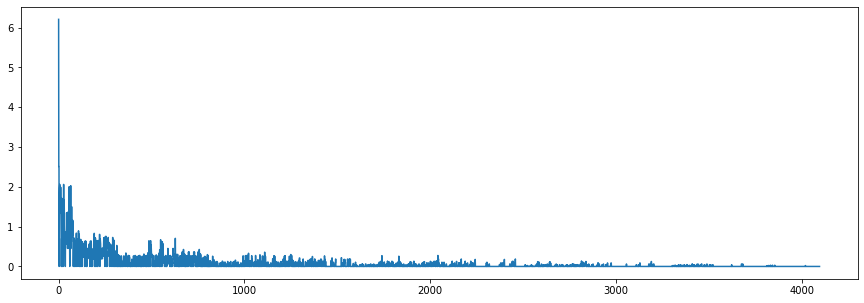

In [19]:
fig_2 = plt.figure(figsize=(15,5))
mean_abs_terms = np.sum(np.abs(all_terms_list_np), axis=0)
plt.plot(mean_abs_terms)
plt.show()

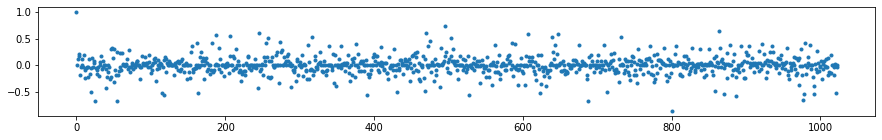

In [20]:
# Sum of all_terms vs Pauli observable
#
plt.figure(figsize=(15,2))
plt.plot([np.sum(all_terms) for all_terms in all_terms_list_np], marker=".", linestyle="None")

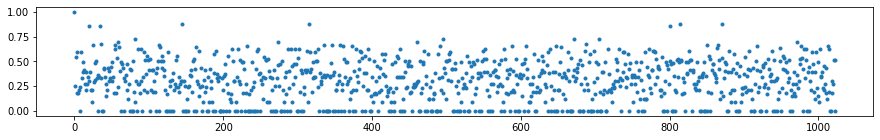

In [21]:
# One-norm of all_terms vs Pauli observable
plt.figure(figsize=(15,2))
plt.plot(np.sum(np.abs(all_terms_list_np), axis=1), marker=".", linestyle="None")

## Comparison between exact and approximated results

In [22]:
# If True, sorts both ideal and approximate results with respect to ideal results
sort = False

zipped_expvals = np.array(sorted(zip(direct_expvals, heis_expvals_approx), key=lambda x: sort * x[0]))
direct_expvals_sorted = zipped_expvals[::, 0]
heis_expvals_approx_sorted = zipped_expvals[::, 1]

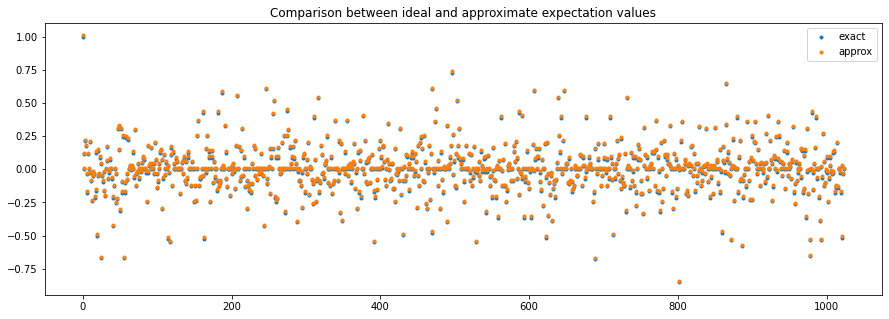

In [23]:
plt.figure(figsize=(15,5))
plt.plot(direct_expvals_sorted, marker = ".", linestyle="None", label="exact")
plt.plot(np.array(heis_expvals_approx_sorted) + 0.01, marker = ".", linestyle="None", label="approx")
plt.title("Comparison between ideal and approximate expectation values")
plt.legend()
plt.show()

In [24]:
# Mean squared error
np.square(direct_expvals_sorted - heis_expvals_approx_sorted).mean()

9.601263766803088e-31

In [25]:
# Trivial mse
trivial_mse = np.square(direct_expvals_sorted - 0 * heis_expvals_approx_sorted).mean()
trivial_mse

0.03124999999999965

In [26]:
# Fraction of correct outcomes
np.sum(np.isclose(direct_expvals_sorted, heis_expvals_approx_sorted)) / len(direct_expvals_sorted)

1.0

In [27]:
# Fraction of correct outcomes with trival estimate
trivial_fraction = np.sum(np.isclose(direct_expvals_sorted, 0 * heis_expvals_approx_sorted)) / len(direct_expvals_sorted)
trivial_fraction

0.2138671875

In [28]:
# Worst case error
np.max(direct_expvals_sorted - heis_expvals_approx_sorted)

4.6629367034256575e-15

## Analysis of truncation factor

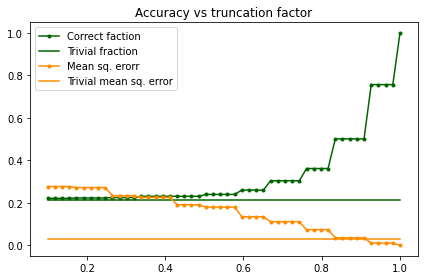

In [29]:
if sort:
    raise RuntimeError("Sort must be False")

num_truncations = 50
truncations = np.linspace(0.1, truncation_factor, num_truncations)
fractions = []
mses = [] 
for trunc in truncations:
    this_max_z_weight = int(num_t * trunc)
    trunc_expvals = np.sum(all_terms_list_np[:, : 2 ** this_max_z_weight], axis=1)
    # Fraction of correct outcomes
    fractions.append(np.sum(np.isclose(direct_expvals_sorted, trunc_expvals)) / num_paulis)
    mses.append(np.square(direct_expvals_sorted - trunc_expvals).mean())

plt.plot(truncations, fractions, marker = ".", linestyle="-", color="darkgreen", label="Correct faction")
plt.plot(truncations, 0 * truncations + trivial_fraction, color="darkgreen", label="Trivial fraction")

plt.plot(truncations, 10 * np.array(mses), marker = ".", linestyle="-", color="darkorange", label="Mean sq. erorr")
plt.plot(truncations, 0 * truncations + trivial_mse, color="darkorange", label="Trivial mean sq. error")

plt.title("Accuracy vs truncation factor")
plt.legend()
plt.tight_layout()
plt.show()